In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle
from sklearn.model_selection import cross_val_score


In [2]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [3]:
# Load data
data_train = pd.read_csv('../Dataset/train_data.csv')
data_test = pd.read_csv('../Dataset/test_data.csv')

In [4]:
X_train = data_train['article']
y_train = data_train['label']

X_test = data_test['article']
y_test = data_test['label']

In [5]:
# Text preprocessing
def wordopt(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('../Resources/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [6]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_test
X_test = X_test.apply(preprocess)

In [7]:
# Convert the preprocessed text into a list of strings
X_train_processed = [' '.join(tokens) for tokens in X_train]
X_test_processed = [' '.join(tokens) for tokens in X_test]

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)

# Transform the validation data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

# Print the shape of the TF-IDF matrices (No of rows, No of columns)
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (2103, 27707)
Shape of X_test_tfidf: (902, 27707)


In [8]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

# mnb = MultinomialNB(alpha= 0.1, fit_prior=False)
# lr = LogisticRegression(C= 100, penalty= 'l2', solver= 'liblinear')
# rf = RandomForestClassifier(n_estimators= 300, random_state=42)
# knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 5, weights= 'uniform')
# svm = SVC(C=10, degree=2, kernel = 'linear', probability = True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [9]:
stack_rf = joblib.load('../Models/Stack/stack_rf_5_final_953.joblib')
stack_lr = joblib.load('../Models/Stack/stack_lr.joblib')
stack_svm = joblib.load('../Models/Stack/stack_svm.joblib')
stack_mlp = joblib.load('../Models/Stack/stack_mlp_2_958.joblib')

models = [
    (stack_lr, 'Logistic Regression'),
    (stack_rf, 'Random Forest'),
    (stack_svm, 'Support Vector Machine'),
    (stack_mlp, 'Multi-layer Perceptron'),
]

In [10]:

base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in  zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_train_tfidf)
    y_prob = model.predict_proba(X_train_tfidf)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    auc = roc_auc_score(y_train, y_prob)

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]


# Evaluate stacking models
def get_performance_stats(model, name):
    stack_y_pred = model.predict(X_train_tfidf)
    stack_y_prob = model.predict_proba(X_train_tfidf)[:, 1]

    stack_accuracy = accuracy_score(y_train, stack_y_pred)
    stack_precision = precision_score(y_train, stack_y_pred)
    stack_recall = recall_score(y_train, stack_y_pred)
    stack_f1 = f1_score(y_train, stack_y_pred)
    stack_auc = roc_auc_score(y_train, stack_y_prob)
    metrics_df.loc[name] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]

metrics_df.loc['Stacking Model'] = ["", "", "", "", ""]

for model, name in models:
    get_performance_stats(model, name)

# Display the comparison table
print("Comparison of Models: (TRAINING)")
print(metrics_df)

Comparison of Models: (TRAINING)
                        Accuracy Precision    Recall  F1 Score       AUC
MNB                      0.94912  0.910823  0.996212  0.951606  0.996599
LR                        0.9767  0.994112   0.95928  0.976386  0.999159
RF                           1.0       1.0       1.0       1.0       1.0
KNN                     0.913932  0.871708  0.971591  0.918943   0.98205
SVM                          1.0       1.0       1.0       1.0       1.0
Stacking Model                                                          
Logistic Regression          1.0       1.0       1.0       1.0       1.0
Random Forest                1.0       1.0       1.0       1.0       1.0
Support Vector Machine       1.0       1.0       1.0       1.0       1.0
Multi-layer Perceptron       1.0       1.0       1.0       1.0       1.0


In [11]:

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
base_models = [mnb, lr, rf, knn, svm]

print("TRAINING BASE MODEL ACCURACY")
for model, name in zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy') 
    mean_accuracy = scores.mean()

    joblib.dump(model, '../Models/Base/basemodel_' + str(name) + '.joblib')
    print(name, '%.4f' % mean_accuracy)
    print(name, np.around(scores, decimals=4))
    print()
    



TRAINING BASE MODEL ACCURACY
MNB 0.8312
MNB [0.8337 0.829  0.8147 0.8548 0.8238]

LR 0.9263
LR [0.9264 0.924  0.924  0.9333 0.9238]

RF 0.9287
RF [0.9145 0.924  0.9406 0.931  0.9333]

KNN 0.8578
KNN [0.8694 0.8432 0.8456 0.8595 0.8714]

SVM 0.9358
SVM [0.9382 0.9287 0.9359 0.9405 0.9357]



In [12]:
basemodel_mnb = joblib.load('../Models/Base/basemodel_MNB_grid.joblib')
basemodel_lr = joblib.load('../Models/Base/basemodel_LR_grid.joblib')
basemodel_rf = joblib.load('../Models/Base/basemodel_RF_grid.joblib')
basemodel_knn = joblib.load('../Models/Base/basemodel_KNN_grid.joblib')
basemodel_svm = joblib.load('../Models/Base/basemodel_SVM_grid.joblib')


base_names_grid = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
base_models_grid = [basemodel_mnb, basemodel_lr, basemodel_rf, basemodel_knn, basemodel_svm]



In [13]:
metrics_df = pd.DataFrame(columns=['Mean Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# Initialize lists to store ROC curve data
plt.figure()

print("TRAINING BASE MODEL ACCURACY")
for model, name in zip(base_models_grid, base_names_grid):
    model.fit(X_train_tfidf, y_train)
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    scores_precision = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='precision')
    scores_recall = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='recall')
    scores_f1 = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1')
    scores_roc_auc = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='roc_auc') 
    mean_accuracy = scores.mean()
    mean_scores_precision = scores_precision.mean()
    mean_scores_recall = scores_recall.mean()
    mean_scores_f1 = scores_f1.mean()
    mean_scores_roc_auc = scores_roc_auc.mean()

    metrics_df.loc[name] = [
        mean_accuracy, 
        mean_scores_precision,
        mean_scores_recall,
        mean_scores_f1,
        mean_scores_roc_auc,
    ]
print(metrics_df)


TRAINING BASE MODEL ACCURACY
     Mean Accuracy  Precision    Recall  F1 Score   ROC AUC
MNB       0.908242   0.881606  0.944143  0.911744  0.973613
LR        0.951983   0.978974  0.924256  0.950827  0.990898
RF        0.930577   0.936114  0.925186  0.930457  0.982301
KNN       0.857829   0.806495  0.943199  0.869470  0.942442
SVM       0.950076   0.973173  0.926147  0.949072  0.991120


<Figure size 640x480 with 0 Axes>

In [16]:
metrics_df = pd.DataFrame(columns=['Mean Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# Initialize lists to store ROC curve data
plt.figure()

print("TRAINING BASE MODEL ACCURACY")
for model, name in zip(base_models_grid, base_names_grid):
    model.fit(X_train_tfidf, y_train)
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=18, scoring='accuracy')
    scores_precision = cross_val_score(model, X_train_tfidf, y_train, cv=18, scoring='precision')
    scores_recall = cross_val_score(model, X_train_tfidf, y_train, cv=18, scoring='recall')
    scores_f1 = cross_val_score(model, X_train_tfidf, y_train, cv=18, scoring='f1')
    scores_roc_auc = cross_val_score(model, X_train_tfidf, y_train, cv=18, scoring='roc_auc') 
    mean_accuracy = scores.mean()
    mean_scores_precision = scores_precision.mean()
    mean_scores_recall = scores_recall.mean()
    mean_scores_f1 = scores_f1.mean()
    mean_scores_roc_auc = scores_roc_auc.mean()

    metrics_df.loc[name] = [
        mean_accuracy, 
        mean_scores_precision,
        mean_scores_recall,
        mean_scores_f1,
        mean_scores_roc_auc,
    ]

print(metrics_df)


TRAINING BASE MODEL ACCURACY
     Mean Accuracy  Precision    Recall  F1 Score   ROC AUC
MNB       0.909679   0.887214  0.941344  0.912912  0.975469
LR        0.950085   0.973581  0.926115  0.948564  0.991848
RF        0.932958   0.941673  0.924200  0.932374  0.982335
KNN       0.860239   0.810109  0.948000  0.872675  0.945829
SVM       0.954838   0.972894  0.936571  0.953824  0.992451


<Figure size 640x480 with 0 Axes>

In [19]:
stack_mlp = joblib.load('../Models/Grid/grid_mlp_3.joblib')
stack_mlp.fit(X_train_tfidf, y_train)
models = [
    (stack_lr, 'Logistic Regression'),
    (stack_rf, 'Random Forest'),
    (stack_svm, 'Support Vector Machine'),
    (stack_mlp, 'Multi-layer Perceptron'),
]


Comparison of Models: (TESTING)
                        Accuracy Precision    Recall  F1 Score       AUC
MNB                     0.834812  0.760274  0.980132  0.856316  0.969867
LR                      0.922395  0.946387  0.896247  0.920635  0.978131
RF                      0.924612  0.936508    0.9117  0.923937  0.978766
KNN                     0.871397  0.824663  0.944812  0.880658  0.950515
SVM                     0.939024  0.962791  0.913907  0.937712  0.982733
Stacking Model                                                          
Logistic Regression     0.946785  0.943107  0.951435  0.947253  0.986971
Random Forest           0.953437  0.951648   0.95585  0.953744  0.985976
Support Vector Machine  0.949002  0.939525  0.960265  0.949782  0.983913
Multi-layer Perceptron  0.945676  0.954955  0.935982  0.945373  0.985664


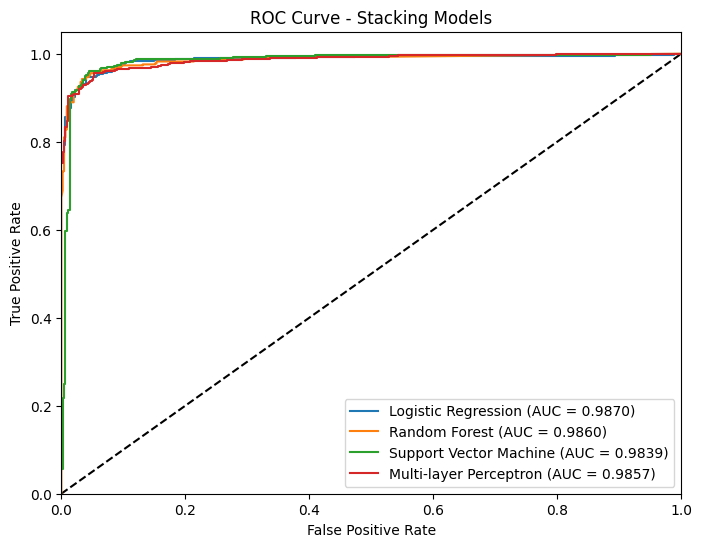

In [20]:
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in  zip(base_models , base_names):
    y_pred = model.predict(X_test_tfidf)
    y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

# Initialize the figure
plt.figure(figsize=(8, 6))

# Plot the baseline of a random classifier
plt.plot([0, 1], [0, 1], 'k--')

# Evaluate stacking models
def get_performance_stats(model, name):
    stack_y_pred = model.predict(X_test_tfidf)
    stack_y_prob = model.predict_proba(X_test_tfidf)[:, 1]  

    stack_accuracy = accuracy_score(y_test, stack_y_pred)
    stack_precision = precision_score(y_test, stack_y_pred)
    stack_recall = recall_score(y_test, stack_y_pred)
    stack_f1 = f1_score(y_test, stack_y_pred)
    stack_auc = roc_auc_score(y_test, stack_y_prob)
    metrics_df.loc[name] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]

    stack_fpr, stack_tpr, _ = roc_curve(y_test, stack_y_prob)
    stack_roc_auc = roc_auc_score(y_test, stack_y_prob)

    plt.plot(stack_fpr, stack_tpr, label=f'{name} (AUC = {stack_roc_auc:.4f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Stacking Models')
    plt.legend(loc="lower right")

metrics_df.loc['Stacking Model'] = ["", "", "", "", ""]

for model, name in models:
    get_performance_stats(model, name)

# Display the comparison table
print("Comparison of Models: (TESTING)")
print(metrics_df)